In [1]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import string
import plotly.graph_objects as go

In [2]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff']
plotted_models = ['DPN','ReXNet', 'EseVoVNet', 'TNT', 'Inception', 'HRNet', 'MobileNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_Magface', 'DPN_Cosface', 'SMAC']

In [3]:
models = get_finished_models_Phase1B()

rank_files = glob.glob('Phase1B/**/*_rank_by_id_val.csv')
rank_files += glob.glob('timm_explore_few_epochs/**/*_rank_by_id_val.csv')
rank_files_Phase1 = [x for x in rank_files if any([m in x for m in models])]
kacc_files = glob.glob('**/**/*_kacc_val.csv')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')

epochs = ['epoch_'+str(i) for i in [19,39,59,79,99]]

acc_df, acc_disp_df, rank_df = analyze_rank_files(rank_files_Phase1, metadata, epochs=epochs)
_, acc_disp_ratio_df, rank_ratio_df = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, epochs=epochs)
err_df, error_ratio_df, _ = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, error=True, epochs=epochs)

In [4]:
acc_df['Metric'] = 1 - acc_df['Metric']

In [5]:
df = merge(acc_df, rank_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['model'])
meta = pd.read_csv('../timm_model_metadata.csv')
df = df.merge(meta, left_on='model', right_on='model_name', suffixes=('_x', ''))
df.fillna('0',inplace=True)
df['n_feature_params'] = np.log(df['n_feature_params'])

In [35]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

y = df['Disparity'] # dependent variable
X = df[[
        'n_feature_params',
       ]
    +[x for x in list(meta.columns[8:13])+list(meta.columns[16:]) 
          if len(df[x].unique())>5]
].astype(float) # independent variable
X = pd.get_dummies(data=X, drop_first=True)

X = sm.add_constant(X) # adding a constant
lm = sm.OLS(y, X).fit() # fitting the model


tbl = Stargazer([lm])
tbl.show_confidence_intervals(True)
tbl.custom_columns(['Statisitcal Parity'], 
                   [1])
tbl


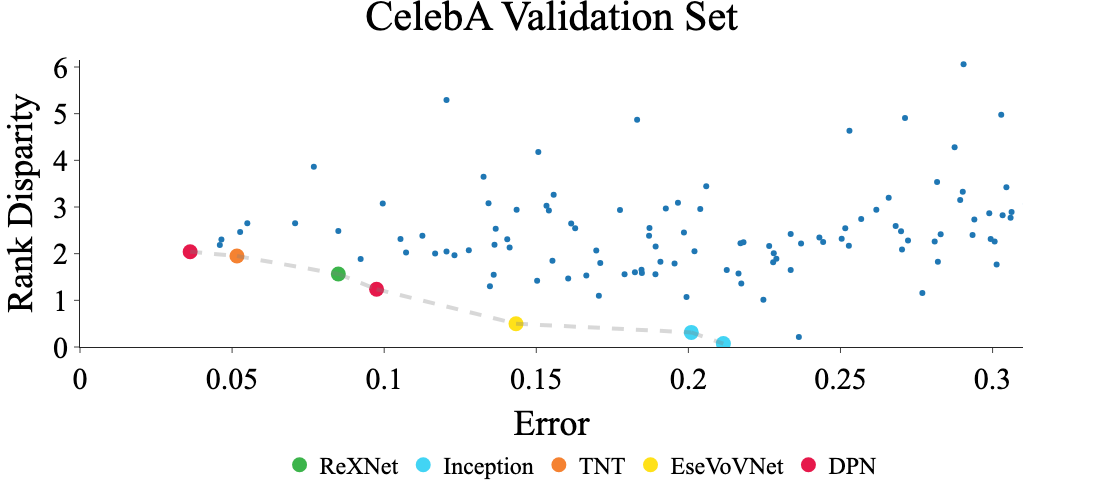

In [13]:
import plotly
df = merge(acc_df, rank_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 template="simple_white", 
                 width=1000, height= 500
            )

fig.update_layout(
    yaxis_title="Rank Disparity",
    yaxis_range=[0,6.15],
    xaxis_range=[0,.31],
    title={
            'text' : "CelebA Validation Set",
            'x':0.5,
            'xanchor': 'center'
        },
    font=dict(
        family="Times New Roman",
        size=30,
        color="Black"
    )
)
fig.add_shape(type='line',
                x0=0,y0=0,x1=1,y1=0,
                line=dict(color='Red',),
                xref='x',yref='y'
)
p = np.array(preparePareto(df[['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-.49,
    xanchor="right",
    x=.85,
    font=dict(
        family="Times New Roman",
        size=24,
        color="Black"
    )
    )
)

pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error","Disparity"])
for model in set(pareto_df['model']):
    # match model name to color
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Disparity'],
        mode='markers',
        name = name,
        marker = dict(color=color,size=15),
    ))

fig.show()
plotly.io.write_image(fig, 'RQ1_main.pdf', format='pdf')

In [93]:
df.sort_values('Error')

,index,epoch,Error,Disparity,model
1657,dpn107_CosFace_SGD_0.1_cosine_rank_by_id_val,99,0.036210,2.041776,dpn107
1459,rexnet_200_CosFace_SGD_rank_by_id_val,99,0.045966,2.185568,rexnet_200
1470,rexnet_200_CosFace_SGD_0.1_cosine_rank_by_id_val,99,0.046490,2.301598,rexnet_200
1591,tnt_s_patch16_224_CosFace_AdamW_rank_by_id_val,99,0.051598,1.949450,tnt_s_patch16_224
1713,dpn107_CosFace_AdamW_rank_by_id_val,99,0.052645,2.465558,dpn107
...,...,...,...,...,...
1460,xception_CosFace_Adam_rank_by_id_val,99,0.996988,1.066658,xception
1702,tf_efficientnet_b7_ns_ArcFace_SGD_rank_by_id_val,99,0.997053,1.445783,tf_efficientnet_b7_ns
1737,tf_efficientnet_b7_ns_ArcFace_AdamW_rank_by_id...,99,0.997708,2.697355,tf_efficientnet_b7_ns
1649,tf_efficientnet_b7_ns_ArcFace_SGD_0.1_cosine_r...,99,0.998167,6.101755,tf_efficientnet_b7_ns


In [147]:
acc_df, acc_disp_df, rank_df = analyze_rank_files_np(rank_files_Phase1, metadata, epochs=['epoch_'+str(i) for i in [19,39,59,79,99]])

In [7]:
high_perf_models = df[df['Error']<0.3]['index']

In [136]:
acc_df

,index,epoch,Metric
0,vgg19_bn_MagFace_SGD_0.1_cosine_rank_by_id_val,19,0.711957
1,ig_resnext101_32x8d_ArcFace_AdamW_rank_by_id_val,19,0.640126
2,rexnet_200_CosFace_AdamW_rank_by_id_val,19,0.012572
3,resnetrs101_CosFace_SGD_rank_by_id_val,19,0.876572
4,legacy_senet154_ArcFace_AdamW_0.001_cosine_ran...,19,0.722826
...,...,...,...
1770,dla102x2_ArcFace_SGD_rank_by_id_val,99,0.660555
1771,swin_base_patch4_window7_224_CosFace_SGD_rank_...,99,0.033133
1772,dla102x2_MagFace_SGD_rank_by_id_val,99,0.648573
1773,coat_lite_small_ArcFace_AdamW_rank_by_id_val,99,0.000000


In [126]:
def analyze_rank_files_np(files, metadata, ratio=False, error=False, epochs=None): 
    if epochs is None:
        epochs = ['epoch_'+str(e) for e in range(100)]
        
    acc_df = pd.DataFrame(columns=epochs)
    acc_ratio_df = pd.DataFrame(columns=epochs)
    rank_df = pd.DataFrame(columns=epochs)
    
    for f in files:
        try:
            df = pd.read_csv(f)
        except:
            continue
        epoch_columns = list(set(df.columns).intersection(epochs))
        df = metadata.merge(df)
        num_epochs = len(epoch_columns)
        print(df)
        if error:
            acc = err_from_rank_func(df, epoch_columns)
        else:
            acc = acc_from_rank_func(df, epoch_columns)
        print(acc)
        experiment = get_name_details(f)[0]
        acc_df.loc[experiment] = acc
        
        if ratio:
            if error:
                acc_disp = ratio_errors_func(df, epoch_columns)
            else:
                acc_disp = stat_parity_ratio_rank_func(df, epoch_columns)
        else:
            acc_disp = stat_parity_rank_func(df, epoch_columns)
        acc_ratio_df.loc[experiment] = acc_disp 
        
        if ratio:
            rank_ratio = rank_ratio_func(df, epoch_columns)
        else:
            rank_ratio = rank_func(df, epoch_columns)
        rank_df.loc[experiment] = rank_ratio    
    return acc_df, acc_ratio_df, rank_df

In [148]:
acc_df

,epoch_19,epoch_39,epoch_59,epoch_79,epoch_99
vgg19_bn_MagFace_SGD_0.1_cosine_rank_by_id_val,0.711957,0.763489,0.768924,0.762572,0.755697
ig_resnext101_32x8d_ArcFace_AdamW_rank_by_id_val,0.640126,0.683604,0.658460,0.660162,0.659049
rexnet_200_CosFace_AdamW_rank_by_id_val,0.012572,0.016959,0.021346,0.024555,0.030775
resnetrs101_CosFace_SGD_rank_by_id_val,0.876572,0.895888,0.880566,0.864523,0.872184
legacy_senet154_ArcFace_AdamW_0.001_cosine_rank_by_id_val,0.722826,0.631024,0.554020,0.517548,0.520299
...,...,...,...,...,...
dla102x2_ArcFace_SGD_rank_by_id_val,0.813449,0.832700,0.780382,0.684586,0.660555
swin_base_patch4_window7_224_CosFace_SGD_rank_by_id_val,0.040925,0.033853,0.032347,0.033329,0.033133
dla102x2_MagFace_SGD_rank_by_id_val,0.762310,0.802514,0.795508,0.706653,0.648573
coat_lite_small_ArcFace_AdamW_rank_by_id_val,0.001899,0.002095,0.002488,0.000000,0.000000


In [8]:
# there is low correlation between \xaxis{} and rank disparity ($\rho = -.113$ for models with error < 0.3)
from scipy.stats import pearsonr
pearsonr(df[df['Error']<0.3]['Error'], df[df['Error']<0.3]['Disparity'])

(0.1129898920846963, 0.2465525023252706)

In [150]:
acc_df, acc_disp_df, rank_df = analyze_rank_files_np(rank_files_Phase1, metadata, epochs=['epoch_'+str(i) for i in [19,39,59,79,99]])
acc_df

,epoch_19,epoch_39,epoch_59,epoch_79,epoch_99
vgg19_bn_MagFace_SGD_0.1_cosine_rank_by_id_val,0.711957,0.763489,0.768924,0.762572,0.755697
ig_resnext101_32x8d_ArcFace_AdamW_rank_by_id_val,0.640126,0.683604,0.658460,0.660162,0.659049
rexnet_200_CosFace_AdamW_rank_by_id_val,0.012572,0.016959,0.021346,0.024555,0.030775
resnetrs101_CosFace_SGD_rank_by_id_val,0.876572,0.895888,0.880566,0.864523,0.872184
legacy_senet154_ArcFace_AdamW_0.001_cosine_rank_by_id_val,0.722826,0.631024,0.554020,0.517548,0.520299
...,...,...,...,...,...
dla102x2_ArcFace_SGD_rank_by_id_val,0.813449,0.832700,0.780382,0.684586,0.660555
swin_base_patch4_window7_224_CosFace_SGD_rank_by_id_val,0.040925,0.033853,0.032347,0.033329,0.033133
dla102x2_MagFace_SGD_rank_by_id_val,0.762310,0.802514,0.795508,0.706653,0.648573
coat_lite_small_ArcFace_AdamW_rank_by_id_val,0.001899,0.002095,0.002488,0.000000,0.000000


In [149]:
def analyze_files_pd(pd_dict_list, metadata, ratio=False, error=False, epochs=None):
    if epochs is None:
        epochs = ['epoch_'+str(e) for e in range(100)]
        
    acc_df = pd.DataFrame(columns=epochs)
    acc_ratio_df = pd.DataFrame(columns=epochs)
    rank_df = pd.DataFrame(columns=epochs)
    
    for d in pd_dict_list:
        experiment = d['experiment']
        df = d['df']
        epoch_columns = list(set(df.columns).intersection(epochs))
        df = metadata.merge(df)
        if error:
            acc = err_from_rank_func(df, epoch_columns)
        else:
            acc = acc_from_rank_func(df, epoch_columns)
        acc_df.loc[experiment] = acc
        
        if ratio:
            if error:
                acc_disp = ratio_errors_func(df, epoch_columns)
            else:
                acc_disp = stat_parity_ratio_rank_func(df, epoch_columns)
        else:
            acc_disp = stat_parity_rank_func(df, epoch_columns)
        acc_ratio_df.loc[experiment] = acc_disp 
        
        if ratio:
            rank_ratio = rank_ratio_func(df, epoch_columns)
        else:
            rank_ratio = rank_func(df, epoch_columns)
        rank_df.loc[experiment] = rank_ratio    
    return acc_df, acc_ratio_df, rank_df

def analyze_rank_files_np(files, metadata, ratio=False, error=False, epochs=None): 
    if epochs is None:
        epochs = ['epoch_'+str(e) for e in range(100)]
        
    acc_df = pd.DataFrame(columns=epochs)
    acc_ratio_df = pd.DataFrame(columns=epochs)
    rank_df = pd.DataFrame(columns=epochs)
    
    for f in files:
        try:
            df = pd.read_csv(f)
        except:
            continue
        epoch_columns = list(set(df.columns).intersection(epochs))
        df = metadata.merge(df)
        num_epochs = len(epoch_columns)
        if error:
            acc = err_from_rank_func(df, epoch_columns)
        else:
            acc = acc_from_rank_func(df, epoch_columns)
        experiment = get_name_details(f)[0]
        acc_df.loc[experiment] = acc
        
        if ratio:
            if error:
                acc_disp = ratio_errors_func(df, epoch_columns)
            else:
                acc_disp = stat_parity_ratio_rank_func(df, epoch_columns)
        else:
            acc_disp = stat_parity_rank_func(df, epoch_columns)
        acc_ratio_df.loc[experiment] = acc_disp 
        
        if ratio:
            rank_ratio = rank_ratio_func(df, epoch_columns)
        else:
            rank_ratio = rank_func(df, epoch_columns)
        rank_df.loc[experiment] = rank_ratio    
    return acc_df, acc_ratio_df, rank_df

def analyze_rank_files(files, metadata, ratio=False, error=False, epochs=None): 
    pd_dict_list = []
    for f in files:
        try:
            df = pd.read_csv(f)
        else:
            continue
        experiment = get_name_details(f)[0]
        pd_dict_list += [{'experiment':experiment,
                          'df': df}]


    acc_df, acc_ratio_df, rank_df = analyze_files_pd(pd_dict_list, metadata, ratio=ratio, error=error, epochs=epochs)
    return prepare(acc_df), prepare(acc_ratio_df), prepare(rank_df)

def analyze_pickle_files(pickle_files, metadata, ratio=False, error=False, epochs=None):
    for model_pickle_files in pickle_files:
        df = pd.DataFrame()
        for f in model_pickle_files:
            epoch = f.split('_')[-1].split('.')[0]
            pickle_df = pd.read_pickle(f)
            pickle_df.columns = [f'Epoch_{epoch}_'+c for c in pickle_df.columns]
            if df.shape[0]:
                df = pd.merge(df,pickle_df,left_index=True, right_index=True)
            else:
                df = pickle_df

        if df.shape[0] == 0:
            continue

        df = df[[x for x in df.columns if 'nearest_by_id' in x]]
        df.columns = ['epoch_'+x.split('_')[1] for x in df.columns]
        df.reset_index(inplace=True)
        df = df.rename(columns = {'index':'ids'})
        experiment = f.split('/')[1]
        pd_dict_list += [{'experiment':experiment,
                          'df': df}]
        
    acc_df, acc_ratio_df, rank_df = analyze_files_pd(pd_dict_list, metadata, ratio=ratio, error=error, epochs=epochs)
    return prepare(acc_df), prepare(acc_ratio_df), prepare(rank_df)

SyntaxError: invalid syntax (3351950416.py, line 80)

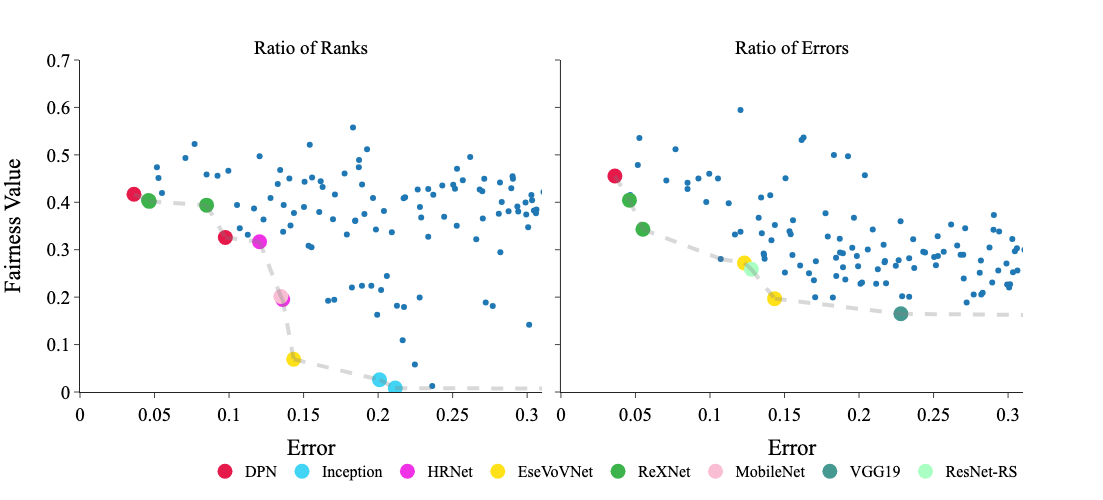

In [9]:
df = merge(err_df, rank_ratio_df)
df = df.rename(columns={'Accuracy':'Error'})
df = merge(df, error_ratio_df)
df = df[df['epoch'] == 99]
df.drop('epoch', axis=1, inplace=True)

df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1].split('_')[0])
df.drop('index', axis=1, inplace=True)
df = df.sort_values(by=['model'])
df = df.rename(columns={'Disparity':'Ratio of Ranks'})
df = df.rename(columns={'Metric':'Ratio of Errors'})
df_non_melt = df
df = df.melt(['model','Error'])


fig = px.scatter(df, x='Error', 
                 y='value', 
                 facet_col='variable',
                 template="simple_white",
                 width=1000, height= 500
            )

fig.update_layout(
    yaxis_title="Fairness Value",
    yaxis_range=[0,.7],
    xaxis_range=[0,.31],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)
# Get Pareto Fronts
p_ratio_ranks = np.array(preparePareto(df_non_melt[['Error','Ratio of Ranks']], False, False).dropna())
pareto_df_ranks = pd.merge(df, pd.DataFrame(p_ratio_ranks), 
                           right_on=[0,1], left_on=["Error","value"])
p_ratio_errors = np.array(preparePareto(df_non_melt[['Error','Ratio of Errors']], False, False).dropna())
pareto_df_error = pd.merge(df, pd.DataFrame(p_ratio_errors), 
                           right_on=[0,1], left_on=["Error","value"])

# # get a list of the models from both sides with error below 0.3
# p_models = list(set(list(set(pareto_df_error[pareto_df_error['Error']<0.3]['model'])) + \
# list(set(pareto_df_ranks[pareto_df_ranks['Error']<0.3]['model']))))
# n_colors = len(p_models)+2
# # turn those models into colors
# colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])
# colors = {x:colors[i] for i, x in enumerate(p_models)}

# plot PFront for Ranks
for x, y in zip(p_ratio_ranks[:-1], p_ratio_ranks[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=1,row=1)
for model in set(pareto_df_ranks['model']):
    if max(pareto_df_ranks[pareto_df_ranks['model'] == model]['Error']) > 0.3:
        continue
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df_ranks[pareto_df_ranks['model'] == model]['Error'],
        y=pareto_df_ranks[pareto_df_ranks['model'] == model]['value'],
        mode='markers',
        name = name,
        marker_color = color,
        marker = dict(size=15),
    ), col=1,row=1)

# plot PFront for Error
for x, y in zip(p_ratio_errors[:-1], p_ratio_errors[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=2,row=1)
for model in set(pareto_df_error['model']):
    if max(pareto_df_error[pareto_df_error['model'] == model]['Error']) > 0.3:
        continue
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df_error[pareto_df_error['model'] == model]['Error'],
        y=pareto_df_error[pareto_df_error['model'] == model]['value'],
        mode='markers',
        name = name,
        marker_color = color,
        marker = dict(size=15),
    ), col=2,row=1)
    
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-.29,
    xanchor="right",
    x=1,
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"
    )
    )
)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))


fig.show()
# plotly.io.write_image(fig, 'ratios.pdf', format='pdf')

In [ ]:
print(f'The number of timm models: {len(models)}')
print(f'The number of training runs completed: {len(rank_files_Phase1)}')
print(f'The number of training runs which performed better than random: {df.shape[0]}')

### Statistical Analyses

In [10]:
df = merge(err_df, rank_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df.loc[:,'head'] = df['index'].apply(lambda x: get_name_details(x)[2])
df.loc[:,'opt'] = df['index'].apply(lambda x: get_name_details(x)[3])
df.loc[:,'Symbol'] = df['model'].apply(lambda x: 0 if x[0] in string.ascii_letters[:10] else 1)
df = df.sort_values(by=['model'])

df

,index,epoch,Error,Disparity,model,head,opt,Symbol
1450,coat_lite_small_MagFace_AdamW_0.001_cosine_ran...,99,0.472368,4.619565,coat_lite_small,MagFace,AdamW,0
1718,coat_lite_small_MagFace_AdamW_rank_by_id_val,99,0.546687,5.306050,coat_lite_small,MagFace,AdamW,0
1614,coat_lite_small_ArcFace_AdamW_0.001_cosine_ran...,99,0.539550,5.471582,coat_lite_small,ArcFace,AdamW,0
1720,coat_lite_small_CosFace_SGD_rank_by_id_val,99,0.290466,6.061027,coat_lite_small,CosFace,SGD,0
1746,coat_lite_small_CosFace_AdamW_rank_by_id_val,99,0.120482,5.292562,coat_lite_small,CosFace,AdamW,0
...,...,...,...,...,...,...,...,...
1560,xception65_MagFace_SGD_0.1_cosine_rank_by_id_val,99,0.339969,2.794657,xception65,MagFace,SGD,1
1638,xception65_CosFace_SGD_rank_by_id_val,99,0.287520,4.281954,xception65,CosFace,SGD,1
1632,xception65_MagFace_AdamW_0.001_cosine_rank_by_...,99,0.369827,3.367339,xception65,MagFace,AdamW,1
1672,xception65_CosFace_AdamW_rank_by_id_val,99,0.519251,7.155055,xception65,CosFace,AdamW,1


In [11]:
phase1b_configs = glob.glob('../configs*/**/*')

In [12]:
import yaml
phase1b_configs = glob.glob('../configs*/**/*')
yamls = [[y for y in phase1b_configs if \
          'config_'+x.replace('_rank_by_id_val','')+'.yaml' in y][0] \
         for x in df['index']]

def get_lr(model):
    y = [y for y in phase1b_configs if \
          'config_'+model.replace('_rank_by_id_val','')+'.yaml' in y][0]
    with open(y, 'r') as file:
        foo = yaml.safe_load(file)
    return foo['lr']
df.loc[:,'lr'] = df['index'].apply(lambda x: get_lr(x))

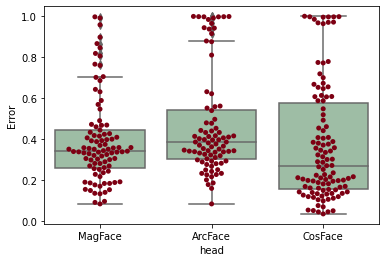

In [13]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='head', y='Error', data=df, color='#99c2a2')
ax = sns.swarmplot(x="head", y="Error", data=df, color='#7d0013')
plt.show()


# different models different pareto dominant hps

In [14]:
models = get_finished_models_Phase1B()

model1 = 'inception_resnet_v2'
model2 = 'xception65'
rank_files = glob.glob(f'../Checkpoints_scratch/{model1}*/*_rank_by_id_val.csv')
rank_files += glob.glob(f'../Checkpoints_scratch/{model2}*/*_rank_by_id_val.csv')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')

epochs = ['epoch_'+str(i) for i in [19,39,59,79,99]]

acc_df, acc_disp_df, rank_df = analyze_rank_files(rank_files, metadata, epochs=epochs)
_, acc_disp_ratio_df, rank_ratio_df = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
err_df, error_ratio_df, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)

In [25]:
import plotly
df = merge(err_df, rank_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df = df[df['Error']<.6]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df.loc[:,'head'] = df['index'].apply(lambda x: get_name_details(x)[-2])
df.loc[:,'opt'] = df['index'].apply(lambda x: get_name_details(x)[-1])
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 color='opt',
                 symbol='head',
                 template="simple_white",
                 facet_col = 'model'
            )

fig.update_layout(
    yaxis_title="Disparity |Rank[male]-Rank[female]|",
    yaxis_range=[0,5.5],
    xaxis_range=[0,.5]
)
fig.add_shape(type='line',
                x0=0,y0=0,x1=1,y1=0,
                line=dict(color='Red',),
                xref='x',yref='y'
)
p = np.array(preparePareto(df[df['model'] == model2][['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1], col=0,row=0,
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
p = np.array(preparePareto(df[df['model'] == model1][['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1], col=1,row=0,
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()
# plotly.io.write_image(fig, 'pareto_diff.pdf', format='pdf')

# transfer

## RFW

In [16]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import plotly.io as pio
pio.renderers.default = 'notebook'
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
metadata = pd.read_csv('RFW_test_identities_ethnicity.csv')
AfAs = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Asian')]
AfAs['gender_expression'] = AfAs.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfAs.to_csv('RFW_AfAs_test_identities_ethnicity.csv')
AfCa = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Caucasian')]
AfCa['gender_expression'] = AfCa.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfCa.to_csv('RFW_AfCa_test_identities_ethnicity.csv')
AfIn = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Indian')]
AfIn['gender_expression'] = AfIn.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfIn.to_csv('RFW_AfIn_test_identities_ethnicity.csv')
AsCa = metadata[np.logical_or(metadata.ethnicity == 'Asian', metadata.ethnicity == 'Caucasian')]
AsCa['gender_expression'] = AsCa.ethnicity.map(lambda x: 'male' if x == 'Asian' else 'female' )
AsCa.to_csv('RFW_AsCa_test_identities_ethnicity.csv')
AsIn = metadata[np.logical_or(metadata.ethnicity == 'Asian', metadata.ethnicity == 'Indian')]
AsIn['gender_expression'] = AsIn.ethnicity.map(lambda x: 'male' if x == 'Asian' else 'female' )
AsIn.to_csv('RFW_AsIn_test_identities_ethnicity.csv')
CaIn = metadata[np.logical_or(metadata.ethnicity == 'Caucasian', metadata.ethnicity == 'Indian')]
CaIn['gender_expression'] = CaIn.ethnicity.map(lambda x: 'male' if x == 'Caucasian' else 'female' )
CaIn.to_csv('RFW_CaIn_test_identities_ethnicity.csv')

In [18]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
rank_files = glob.glob('RFW/**/*_rank_by_id_val.csv')

In [19]:
acc_list_rfw, acc_disp_list_rfw, rank_list_rfw, acc_disp_ratio_list_rfw, rank_ratio_list_rfw, err_list_rfw, error_ratio_list_rfw = [],[],[],[],[],[],[]

for a in ['AfAs', 'AfCa', 'AfIn', 'AsCa', 'AsIn', 'CaIn']:
    metadata = pd.read_csv(f'RFW_{a}_test_identities_ethnicity.csv')

    epochs = ['epoch_'+str(i) for i in [99]]
    acc_df_rfw, acc_disp_df_rfw, rank_df_rfw = analyze_rank_files(rank_files, metadata, epochs=epochs)
    _, acc_disp_ratio_df_rfw, rank_ratio_df_rfw = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
    err_df_rfw, error_ratio_df_rfw, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)
    acc_list_rfw += [acc_df_rfw]
    acc_disp_list_rfw += [acc_disp_df_rfw]
    rank_list_rfw += [rank_df_rfw]
    acc_disp_ratio_list_rfw += [acc_disp_ratio_df_rfw]
    rank_ratio_list_rfw += [rank_ratio_df_rfw]
    err_list_rfw += [err_df_rfw]
    error_ratio_list_rfw += [error_ratio_df_rfw]

In [20]:
from functools import reduce

def reduce_list_rfw(l, f=max):
    df = reduce(lambda x, y: pd.merge(x, y, on = ['index','epoch']), l)

    df['Metric'] = df.loc[:,df.columns.str.startswith('Metric')].apply(lambda x: f(x), axis=1)
    df=df.loc[:,np.logical_not(df.columns.str.startswith('Metric_'))]
    return df

acc_df_rfw = reduce_list_rfw(acc_list_rfw, f=np.mean)
acc_disp_df_rfw = reduce_list_rfw(acc_disp_list_rfw)
rank_df_rfw = reduce_list_rfw(rank_list_rfw)
acc_disp_ratio_df_rfw = reduce_list_rfw(acc_disp_ratio_list_rfw)
rank_ratio_list_rfw = reduce_list_rfw(rank_ratio_list_rfw)
err_df_rfw = reduce_list_rfw(err_list_rfw)
error_ratio_df_rfw = reduce_list_rfw(error_ratio_list_rfw)

In [219]:
df = merge(err_df_rfw, rank_df_rfw)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error','Disparity':'Rank Disparity'})
df = df.dropna()
# df = df[df['Error']<1-1/(7636*2)]
# df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['index'])
# remove 040
df = df[df['index'].apply(lambda x: '040' not in x)]
df_high_perf = df[df['index'].apply(lambda x: x in list(high_perf_models))]
df_high_perf.loc[:,'Model'] = 'timm models'
# df['Disparity'] = np.log(df['Disparity'])
fig = px.scatter(data_frame = df_high_perf
           ,x = 'Error'
           ,y = 'Rank Disparity',
#             color='Model',
             template="simple_white",
                 width=1200, height= 1000
           )
fig.update_traces(marker=dict(size=10))

fig.add_trace(go.Scatter(
    x=df[df['index'].apply(lambda x: 'Check' in x)]['Error'],
    y=df[df['index'].apply(lambda x: 'Check' in x)]['Rank Disparity'],
    mode='markers',
    name = 'SMAC',
    marker_color = colors[-1],
    marker = dict(size=20),
))
# plot PFront
p = np.array(preparePareto(df[df['index'].apply(lambda x: 'Check' not in x)][['Error','Rank Disparity']], 
                           False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=1,row=1)
    
fig.update_layout(
    xaxis_range=[.35,max(df_high_perf['Error'])],
    yaxis_range=[0,500],
    font=dict(
        family="Times New Roman",
        size=38,
        color="Black"
    )
)


pareto_df = pd.merge(df_high_perf, pd.DataFrame(p), 
                           right_on=[0,1], left_on=["Error","Rank Disparity"])
pareto_df.loc[:,'model'] = pareto_df['index'].apply(lambda x: get_name_details(x)[1].split('_')[0])

# plot PFront for Ranks
for model in set(pareto_df['model']):
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Rank Disparity'],
        mode='markers',
        name = name,
        marker_color = color,
        marker = dict(size=20),
    ))

fig.update_layout(showlegend=False)
fig.show()
plotly.io.write_image(fig, '_rfw.png', format='png')

## VGGFace2

In [1]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import string
import plotly.graph_objects as go
import plotly

In [2]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff', 
          '#42d4f4', '#aaffc3', '#000075', '#aaffc3', '#fabed4', '#3cb44b', '#f58231',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff'
         ]
plotted_models = ['DPN','ReXNet', 'EseVoVNet', 'TNT', 'Inception', 'HRNet', 'MobileNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_Magface', 'DPN_Cosface', 'SMAC', 
                 'VisFormer', 'XCeption', 'TF_EfficientNet', 'gluon_xception65', 'dla102x2', 
                 'convit_base', 'twins_svt_large', 'Swin', 'cspdarknet53', 'FBNet', 'JX_Net']

In [3]:
pickle_files = []
for model in glob.glob('vggface2_train/*'):
    pickle_files += [glob.glob(model+'/*[!ema].pkl')]
metadata = pd.read_csv('vggface2_val_identities_gender.csv')

epochs = [f'epoch_{x}' for x in range(10,11)]

acc_df_vgg, acc_disp_df_vgg, rank_df_vgg = analyze_pickle_files(pickle_files, metadata, epochs=epochs)
_, acc_disp_ratio_df_vgg, rank_ratio_df_vgg = analyze_pickle_files(pickle_files, metadata, ratio=True, epochs=epochs)
err_df_vgg, error_ratio_df_vgg, _ = analyze_pickle_files(pickle_files, metadata, ratio=True, error=True, epochs=epochs)

KeyboardInterrupt: 

In [10]:
acc_df_vgg['Metric'] = 1 - acc_df_vgg['Metric']

In [23]:
def plot_figure(metric_name, metric_suffix, fairness_df, 
                error_df=acc_df_vgg, dataset='vggface2', show_all=False, epoch=10):
    df = merge(error_df, fairness_df)
    df = df[df['epoch'] == epoch]
    df = df.rename(columns={'Accuracy':'Error'})
    df = df.dropna()
    if not show_all:
        df = df[df['Error']<0.3]
    else:
        df = df[df['Error']<1-1/(7636*2)]
        
    df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
    df = df.sort_values(by=['model'])
    # df = df.sort_values('Error')[:30]


    fig = px.scatter(df, x='Error', 
                     y='Disparity', 
                     template="simple_white", 
                     width=1000, height= 500
                )

    if metric_name == 'Rank Disparity' and not show_all:
        fig.update_layout(
            xaxis_range=[0,0.32],
            yaxis_range=[-.01,.6]
        )
    fig.update_layout(
        yaxis_title=metric_name,
        title={
                'text' : f'VGGFace2 Validation Set',
                'x':0.5,
                'xanchor': 'center'
            },
        font=dict(
            family="Times New Roman",
            size=30,
            color="Black"
        )
    )
    fig.add_shape(type='line',
                    x0=0,y0=0,x1=1,y1=0,
                    line=dict(color='Red',),
                    xref='x',yref='y'
    )
    p = np.array(preparePareto(df[['Error','Disparity']], False, False).dropna())
    for x, y in zip(p[:-1], p[1:]):
        fig.add_shape(type='line',
                    x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                    line=dict(color='gray',width=4),line_dash='dash',
                    xref='x',yref='y')


    pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error","Disparity"])
    
    if pareto_df.shape[0]<7:
        y_anchor, x_anchor = -.29, .6
    else:
        y_anchor, x_anchor = -.6, .7
        
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.49,
        xanchor="right",
        x=.63,
        font=dict(
            family="Times New Roman",
            size=24,
            color="Black"
        )
        )
    )

    for model in set(pareto_df['model']):
        # match model name to color
        i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
        name = plotted_models[i]
        color = colors[i]
        fig.add_trace(go.Scatter(
            x=pareto_df[pareto_df['model'] == model]['Error'],
            y=pareto_df[pareto_df['model'] == model]['Disparity'],
            mode='markers',
            name = name,
            marker = dict(color=color,size=15),
        ))

    fig.show()
    plotly.io.write_image(fig, f'RQ1_main_{dataset}_{metric_suffix}_17052023.pdf', format='pdf')
    return df


In [14]:
rank_df_vgg.to_csv('foo_rank.csv')
acc_df_vgg.to_csv('foo_acc.csv')

In [3]:
rank_df_vgg = pd.read_csv('foo_rank.csv', index_col=0)
acc_df_vgg = pd.read_csv('foo_acc.csv', index_col=0)

rank_df_vgg = rank_df_vgg[rank_df_vgg['index'].apply(lambda x: 'Checkpoint' not in x)]
acc_df_vgg = acc_df_vgg[acc_df_vgg['index'].apply(lambda x: 'Checkpoint' not in x)]

In [24]:
plot_figure('Rank Disparity', '', rank_df_vgg, show_all=False)
# plot_figure('Disparity','disparity', acc_disp_df_vgg, show_all=True)
# plot_figure('Rank Ratio', 'rank_ratio', rank_ratio_df_vgg, show_all=True)
# plot_figure('Ratio', 'ratio', acc_disp_ratio_df_vgg, show_all=True)
# plot_figure('Error Ratio', 'error_ratio', error_ratio_df_vgg, show_all=True)

,index,epoch,Error,Disparity,model
224,coat_lite_small_CosFace_AdamW,10,0.073333,0.025817,coat_lite_small
202,coat_lite_small_CosFace_AdamW_0.001_cosine,10,0.047124,0.072745,coat_lite_small
276,convit_base_CosFace_AdamW,10,0.054020,0.077908,convit_base
241,convit_base_CosFace_AdamW_0.001_cosine,10,0.058333,0.103987,convit_base
290,convit_base_CosFace_SGD,10,0.185131,2.475163,convit_base
...,...,...,...,...,...
275,xception65_CosFace_SGD,10,0.184248,0.210327,xception65
46,xception65_ArcFace_AdamW_0.001_cosine,10,0.278954,0.635882,xception65
283,xception65_CosFace_SGD_0.1_cosine,10,0.181013,0.306275,xception65
311,xception65_MagFace_AdamW,10,0.241634,0.120915,xception65


In [121]:
plot_figure('Rank Disparity', '', rank_df, error_df=acc_df, dataset='CelebA', show_all=True, epoch=99)
plot_figure('Disparity','disparity', acc_disp_df, error_df=acc_df, dataset='CelebA', show_all=True, epoch=99)
plot_figure('Rank Ratio', 'rank_ratio', rank_ratio_df, error_df=acc_df, dataset='CelebA', show_all=True, epoch=99)
plot_figure('Ratio', 'ratio', acc_disp_ratio_df, error_df=acc_df, dataset='CelebA', show_all=True, epoch=99)
plot_figure('Error Ratio', 'error_ratio', error_ratio_df, error_df=acc_df, dataset='CelebA', show_all=True, epoch=99)

,index,epoch,Error,Disparity,model
1450,coat_lite_small_MagFace_AdamW_0.001_cosine_ran...,99,0.472368,0.253692,coat_lite_small
1718,coat_lite_small_MagFace_AdamW_rank_by_id_val,99,0.546687,0.241946,coat_lite_small
1614,coat_lite_small_ArcFace_AdamW_0.001_cosine_ran...,99,0.539550,0.212969,coat_lite_small
1720,coat_lite_small_CosFace_SGD_rank_by_id_val,99,0.290466,0.373304,coat_lite_small
1746,coat_lite_small_CosFace_AdamW_rank_by_id_val,99,0.120482,0.594347,coat_lite_small
...,...,...,...,...,...
1560,xception65_MagFace_SGD_0.1_cosine_rank_by_id_val,99,0.339969,0.275656,xception65
1638,xception65_CosFace_SGD_rank_by_id_val,99,0.287520,0.304633,xception65
1632,xception65_MagFace_AdamW_0.001_cosine_rank_by_...,99,0.369827,0.275946,xception65
1672,xception65_CosFace_AdamW_rank_by_id_val,99,0.519251,0.145463,xception65


In [90]:
df.sort_values('Error')

,index,epoch,Error,Disparity,model
300,dpn107_CosFace_SGD_0.1_cosine,10,0.022451,0.023660,dpn107
74,dpn107_CosFace_AdamW_0.001_cosine,10,0.022908,0.024641,dpn107
61,rexnet_200_CosFace_SGD_0.1_cosine,10,0.024608,0.092876,rexnet_200
88,dpn107_CosFace_sgd,10,0.032386,0.016797,dpn107
48,rexnet_200_CosFace_SGD,10,0.034444,0.039542,rexnet_200
...,...,...,...,...,...
110,dla102x2_ArcFace_AdamW_0.001_cosine,10,0.295359,0.424118,dla102x2
35,gluon_xception65_ArcFace_AdamW_0.001_cosine,10,0.296046,0.630915,gluon_xception65
31,inception_v4_MagFace_AdamW,10,0.297484,0.829020,inception_v4
188,tf_efficientnet_b7_ns_ArcFace_AdamW,10,0.298431,0.768301,tf_efficientnet_b7_ns


In [ ]:
dpn107_CosFace_SGD_0.1_cosine
dpn107_CosFace_AdamW

In [42]:
from scipy.stats import pearsonr
pearsonr(df[df['Error']<0.3]['Error'], df[df['Error']<0.3]['Disparity'])

(0.3536382178744011, 5.984533417307506e-07)